# Rigid Rods Simulation v1.1 (11/06/19)

In [1]:
from __future__ import division
import hoomd
import hoomd.md
import numpy
import ex_render
from matplotlib import pyplot
%matplotlib inline

## Simulation Parameters

##### Boox size =  4000 
##### Number of particles = 800
##### Chains size = 5 
##### Type of integrator = NPT
##### P_max = 15.0
##### System density = 0.2
##### Run = 1e5 

In [18]:
# Simulation context using hoomd.variant

#-------Define the unit cell

sim1 = hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [5.0, 0,   0],
                            a2 = [0,    1.0, 0],
                            a3 = [0,    0,   1.0],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['R'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);

#-----From the lattice we obtain a snapshot and initialize.

snap = uc.get_snapshot()
snap.replicate(2,20,20)
system = hoomd.init.read_snapshot(snap)

#-----Add the particle type for the constituent particles.

system.particles.types.add('A');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*4,
                positions=[(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies()

#-----Define the potential energy

nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')
lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

#-----Define pressure as a value that varies over time.

pressure = hoomd.variant.linear_interp(points = [(0, 1.0), (1e4, 10.0)], zero = 'now')

#-----Select an NPT integrator

hoomd.md.integrate.mode_standard(dt=0.005);
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.npt(group = rigid, kT = 1.0, tau = 0.5, tauP = 1.0, P = pressure);
hoomd.dump.gsd("trajectory1.gsd",
               period=2e3,
               group=hoomd.group.all(),
               overwrite=True);  

#-----Write output

log = hoomd.analyze.log(filename="log-output1.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure'],
                         period=100,
                         overwrite=True);

notice(2): Group "all" created containing 800 particles
notice(2): constrain.rigid(): Creating 800 rigid bodies (adding 3200 particles)
notice(2): Group "rigid_center" created containing 800 particles


In [42]:
particles = snap.particles.N

lx = snap.box.Lx
ly = snap.box.Ly
lz = snap.box.Lz
volume = lx * ly *lz

density = particles / volume
print(particles, volume ,density)

800 4000.0 0.2


In [31]:
with sim1:
    hoomd.run(1e5)

** starting run **
Time 00:03:46 | Step 14194 / 110000 | TPS 419.139 | ETA 00:03:48
Time 00:03:56 | Step 18334 / 110000 | TPS 413.963 | ETA 00:03:41
Time 00:04:06 | Step 22508 / 110000 | TPS 417.172 | ETA 00:03:29
Time 00:04:16 | Step 26601 / 110000 | TPS 408.98 | ETA 00:03:23
Time 00:04:26 | Step 30671 / 110000 | TPS 406.94 | ETA 00:03:14
Time 00:04:36 | Step 34681 / 110000 | TPS 400.957 | ETA 00:03:07
Time 00:04:46 | Step 38900 / 110000 | TPS 421.857 | ETA 00:02:48
Time 00:04:56 | Step 43019 / 110000 | TPS 411.784 | ETA 00:02:42
Time 00:05:06 | Step 47145 / 110000 | TPS 412.597 | ETA 00:02:32
Time 00:05:16 | Step 51270 / 110000 | TPS 412.449 | ETA 00:02:22
Time 00:05:26 | Step 55413 / 110000 | TPS 414.286 | ETA 00:02:11
Time 00:05:36 | Step 59692 / 110000 | TPS 427.847 | ETA 00:01:57
Time 00:05:46 | Step 63985 / 110000 | TPS 429.269 | ETA 00:01:47
Time 00:05:56 | Step 68093 / 110000 | TPS 410.555 | ETA 00:01:42
Time 00:06:06 | Step 72342 / 110000 | TPS 424.883 | ETA 00:01:28
Time 00:

Size: 2214.19140625 KiB


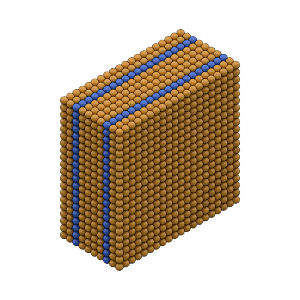

In [43]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory1.gsd');

## Parámetro de orden nemático

In [32]:
import gsd
import gsd.hoomd

In [33]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = numpy.empty(numpy.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        numpy.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, numpy.newaxis] * qj[..., 1:] +
                       qj[..., 0, numpy.newaxis] * qi[..., 1:] +
                       numpy.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = numpy.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [34]:
t1 = gsd.hoomd.open('trajectory1.gsd', 'rb')

In [35]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, numpy.array([1, 0, 0]))

    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [36]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, numpy.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( numpy.outer(arrowheads[i],arrowheads[i])  )
        
    Q = numpy.mean(results, axis=0)  # calculate mean without flattening array
    Q -= numpy.identity(3)/3.0       # subtract Identity/3
    
    return(Q)

In [37]:
nematicOrderTensor(0,t1)

array([[ 0.66666667,  0.        ,  0.        ],
       [ 0.        , -0.33333333,  0.        ],
       [ 0.        ,  0.        , -0.33333333]])

In [38]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = numpy.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [39]:
nematization(9,t1)

0.7054631176928778

In [40]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

(0, 1.1)

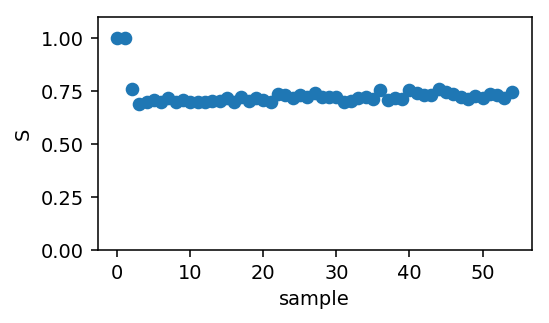

In [41]:
pyplot.figure(figsize=(4,2.2), dpi=140);

s1= sList(t1)

pyplot.scatter(
    numpy.arange(len(s1)), 
    s1);

pyplot.xlabel('sample');
pyplot.ylabel('S');
pyplot.ylim((0,1.1))